### Boilerplate

In [ ]:
%pip install -r ../requirements.txt && pip install matplotlib

### Generate Matches

In [ ]:
%python evaluate.py --config /srv/transparency/wildbook_prototype/data/beluga_example_miewid/model/config.yaml --visualize

### Load precomputed list of matches

We have generated a match list on the MiewID Beluga test dataset and stored it at ```/srv/transparency/wildbook_prototype/data/matches```.

In [1]:
from utils import *
df_test, test_dataset, match_results, q_pids, topk_idx, topk_names, match_mat, distmat, images = load_miewid_data('/home/cabidi/XAI/wbia-plugin-miew-id/wbia_miew_id/runs/miewid-training/beluga-example-exp-1/visualizations')

[PosixPath('/home/cabidi/XAI/wbia-plugin-miew-id/wbia_miew_id/runs/miewid-training/beluga-example-exp-1/visualizations/vis_147_up_558_top20.jpg'), PosixPath('/home/cabidi/XAI/wbia-plugin-miew-id/wbia_miew_id/runs/miewid-training/beluga-example-exp-1/visualizations/vis_110_up_419_top20.jpg'), PosixPath('/home/cabidi/XAI/wbia-plugin-miew-id/wbia_miew_id/runs/miewid-training/beluga-example-exp-1/visualizations/vis_90_up_359_top20.jpg'), PosixPath('/home/cabidi/XAI/wbia-plugin-miew-id/wbia_miew_id/runs/miewid-training/beluga-example-exp-1/visualizations/vis_19_up_114_top20.jpg'), PosixPath('/home/cabidi/XAI/wbia-plugin-miew-id/wbia_miew_id/runs/miewid-training/beluga-example-exp-1/visualizations/vis_124_up_471_top20.jpg'), PosixPath('/home/cabidi/XAI/wbia-plugin-miew-id/wbia_miew_id/runs/miewid-training/beluga-example-exp-1/visualizations/vis_128_up_497_top20.jpg'), PosixPath('/home/cabidi/XAI/wbia-plugin-miew-id/wbia_miew_id/runs/miewid-training/beluga-example-exp-1/visualizations/vis_36_

100%|██████████| 849/849 [00:06<00:00, 127.96it/s]


Loaded images: torch.Size([849, 3, 440, 440])


### LightGlue benchmarking

In [ ]:
### Install LightGlue if necessary
!git clone https://github.com/cvg/LightGlue.git && cd LightGlue && pip install -e .

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
import random
import torch
import os

from matplotlib.backends.backend_agg import FigureCanvasAgg
from collections import defaultdict
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics
from pathlib import Path
from tqdm import tqdm

import lightglue
from lightglue import LightGlue, SuperPoint, DISK, viz2d
from lightglue.utils import rbd

In [17]:
def plot_images(imgs, titles=None, cmaps="gray", dpi=100, pad=0.5, adaptive=True, bordercolor='green'):
    """Plot a set of images horizontally.
    Args:
        imgs: list of NumPy RGB (H, W, 3) or PyTorch RGB (3, H, W) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
        adaptive: whether the figure size should fit the image aspect ratios.
    """
    # conversion to (H, W, 3) for torch.Tensor
    imgs = [
        img.permute(1, 2, 0).cpu().numpy()
        if (isinstance(img, torch.Tensor) and img.dim() == 3)
        else img
        for img in imgs
    ]

    n = len(imgs)
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n

    if adaptive:
        ratios = [i.shape[1] / i.shape[0] for i in imgs]  # W / H
    else:
        ratios = [4 / 3] * n
    figsize = [sum(ratios) * 4.5, 4.5]
    fig, ax = plt.subplots(
        1, n, figsize=figsize, dpi=dpi, gridspec_kw={"width_ratios": ratios}
    )
    if n == 1:
        ax = [ax]
    for i in range(n):
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmaps[i]))
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        #ax[i].set_axis_off()
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(True)
            spine.set_edgecolor(bordercolor)
            spine.set_linewidth(8)
        if titles:
            ax[i].set_title(titles[i])

    fig.tight_layout(pad=pad)

    return fig, ax

def plot_keypoints(kpts, colors="lime", ps=4, axes=None, a=1.0):
    """Plot keypoints for existing images.
    Args:
        kpts: list of ndarrays of size (N, 2).
        colors: string, or list of list of tuples (one for each keypoints).
        ps: size of the keypoints as float.
    """
    if not isinstance(colors, list):
        colors = [colors] * len(kpts)
    if not isinstance(a, list):
        a = [a] * len(kpts)
    if axes is None:
        axes = plt.gcf().axes
    for ax, k, c, alpha in zip(axes, kpts, colors, a):
        if isinstance(k, torch.Tensor):
            k = k.cpu().numpy()
        ax.scatter(k[:, 0], k[:, 1], c=c, s=ps, linewidths=0, alpha=alpha)


def plot_matches(kpts0, kpts1, color=None, lw=1.5, ps=4, a=1.0, labels=None, axes=None):
    """Plot matches for a pair of existing images.
    Args:
        kpts0, kpts1: corresponding keypoints of size (N, 2).
        color: color of each match, string or RGB tuple. Random if not given.
        lw: width of the lines.
        ps: size of the end points (no endpoint if ps=0)
        indices: indices of the images to draw the matches on.
        a: alpha opacity of the match lines.
    """
    fig = plt.gcf()
    if axes is None:
        ax = fig.axes
        ax0, ax1 = ax[0], ax[1]
    else:
        ax0, ax1 = axes
    if isinstance(kpts0, torch.Tensor):
        kpts0 = kpts0.cpu().numpy()
    if isinstance(kpts1, torch.Tensor):
        kpts1 = kpts1.cpu().numpy()
    assert len(kpts0) == len(kpts1)
    if color is None:
        color = matplotlib.cm.hsv(np.random.rand(len(kpts0))).tolist()
    elif len(color) > 0 and not isinstance(color[0], (tuple, list)):
        color = [color] * len(kpts0)

    if lw > 0:
        for i in range(len(kpts0)):
            line = matplotlib.patches.ConnectionPatch(
                xyA=(kpts0[i, 0], kpts0[i, 1]),
                xyB=(kpts1[i, 0], kpts1[i, 1]),
                coordsA=ax0.transData,
                coordsB=ax1.transData,
                axesA=ax0,
                axesB=ax1,
                zorder=1,
                color=color[i],
                linewidth=lw,
                clip_on=True,
                alpha=a,
                label=None if labels is None else labels[i],
                picker=5.0,
            )
            line.set_annotation_clip(True)
            fig.add_artist(line)

    # freeze the axes to prevent the transform to change
    ax0.autoscale(enable=False)
    ax1.autoscale(enable=False)

    if ps > 0:
        ax0.scatter(kpts0[:, 0], kpts0[:, 1], c=color, s=ps)
        ax1.scatter(kpts1[:, 0], kpts1[:, 1], c=color, s=ps)

    return fig, [ax0, ax1]

def fig2np(fig) -> np.array:
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    buf = canvas.buffer_rgba()
    return np.asarray(buf)

def plot_stacked_figures(figs):
    image_arrays = [fig2np(fig) for fig in figs]
    f, axarr = plt.subplots(len(figs), 1, figsize=(16, 4 * len(figs)))
    for i in range(len(figs)):
        axarr[i].set_axis_off()
        axarr[i].get_yaxis().set_ticks([])
        axarr[i].get_xaxis().set_ticks([])
        axarr[i].imshow(image_arrays[i])
    plt.tight_layout()

def plot_stacked_images(images):
    f, axarr = plt.subplots(len(images), 1, figsize=(16, 4 * len(images)))
    for i in range(len(images)):
        axarr[i].set_axis_off()
        axarr[i].get_yaxis().set_ticks([])
        axarr[i].get_xaxis().set_ticks([])
        axarr[i].imshow(images[i])
    plt.tight_layout()

def plot_hulls(kpts0, kpts1, axes = None, kwargs: defaultdict = {"dbscan_kwargs":{"eps":0.3, "min_samples":3}}, return_output: bool = False):
    # Figure and axes setup
    fig = plt.gcf()
    if axes is None:
        ax = fig.axes
        ax0, ax1 = ax[0], ax[1]
    else:
        ax0, ax1 = axes
    if isinstance(kpts0, torch.Tensor):
        kpts0 = kpts0.cpu().numpy()
    if isinstance(kpts1, torch.Tensor):
        kpts1 = kpts1.cpu().numpy()
    assert len(kpts0) == len(kpts1)
    
    # Compute the hulls for both sets of keypoints
    if len(kpts0) > 0 and len(kpts1) > 0:
        hulls_kpts0 = compute_convex_polygons(kpts0, dbscan_kwargs=kwargs["dbscan_kwargs"])
        hulls_kpts1 = compute_convex_polygons(kpts1, dbscan_kwargs=kwargs["dbscan_kwargs"])

        # Draw hull lines on left and right axes
        for hulls, ax in zip([hulls_kpts0, hulls_kpts1], [ax0, ax1]):
            for hull in hulls:
                for simplex in hull.simplices:
                    ax.plot(hull.points[simplex, 0], hull.points[simplex, 1], 'k-')

    if return_output:
        return fig, axes, hulls_kpts0, hulls_kpts1
        
    return fig, axes


def compute_convex_polygons(X: ..., dbscan_kwargs: dict = {"eps":0.3, "min_samples":3}) -> [ConvexHull]:
    """A polygon generator that uses the DBSCAN and ConvexHull algorithms from sklearn.

    Args:
        X (np.array, torch.Tensor): (num_samples,...)-shaped array of un-normalized data points
        dbscan_kwargs (dict, optional): kwargs to provide to DBSCAN. Defaults to {"eps":0.5, "min_samples":3}.

    Returns:
        output: a set of k  drawn in the same (un-normalized) coordinate system as X
    """
    if not isinstance(X, type(np.array)):
        X = np.array(X)
    
    # Normalize input data
    scaler = StandardScaler()
    scaler.fit(X)
    X_new = scaler.transform(X)
    # print(f"X mean: {scaler.mean_}\nX variance: {scaler.var_}")

    # Run DBSCAN
    # print(f"Running DBSCAN with args {dbscan_kwargs}")
    db = DBSCAN(**dbscan_kwargs).fit(X_new)

    # Number of clusters in labels, ignoring noise if present.
    # n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    # n_noise_ = list(db.labels_).count(-1)
    # print("Estimated number of clusters: %d" % n_clusters_)
    # print("Estimated number of noise points: %d" % n_noise_)

    # Extract the convex hull for each core sample set
    hulls = []
    for label in set(db.labels_):
        # Condition on samples matching label
        label_mask = np.zeros_like(db.labels_, dtype=bool)
        label_mask[db.labels_ == label] = True
        
        # Condition on samples in current core set
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        
        # Extract core sample set
        core_points = X[core_samples_mask & label_mask]

        # Compute convex hull if there are more samples than lower bound
        if len(core_points) > 3:
            hull = ConvexHull(core_points)
            hulls.append(hull)

    return hulls
    
    # Un-normalize data
    # hulls = np.array(hulls)
    # if len(hulls) > 0:
    #     hulls_denormalized = scaler.inverse_transform(hulls)
    #     return hulls_denormalized
    # return hulls

def _lightglue(image0: torch.Tensor, image1: torch.Tensor) -> dict:
    feats0 = extractor.extract(image0.to(device))
    feats1 = extractor.extract(image1.to(device))
    matches01 = matcher({"image0": feats0, "image1": feats1})
    return feats0, feats1, matches01

def _lightglue_vis(
        image0,
        image1,
        feats0,
        feats1,
        matches01,
        is_match: bool,
        savepath: str | Path | None = None,
        polygon_kwargs: defaultdict = {"dbscan_kwargs":{"eps":0.3, "min_samples":3}},
        return_output: bool = False
    ):
    def unnormalize(img_base):
        aug_mean = np.array([0.485, 0.456, 0.406])
        aug_std = np.array([0.229, 0.224, 0.225])
        unnormalize = transforms.Normalize((-aug_mean / aug_std).tolist(), (1.0 / aug_std).tolist())
        img_unnorm = unnormalize(img_base)

        return img_unnorm

    # Preprocessing
    feats0, feats1, matches01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension
    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]].cpu().numpy(), kpts1[matches[..., 1]].cpu().numpy()

    # Generate plots
    fig, axes = plot_images([unnormalize(image0), unnormalize(image1)], bordercolor='green' if is_match else 'red')
    fig, axes = plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
    fig, axes, hulls0, hulls1 = plot_hulls(m_kpts0, m_kpts1, axes=axes, kwargs=polygon_kwargs, return_output=True)
    viz2d.add_text(0, f"num keypoints={len(m_kpts0)}", fs=20)

    # Save plots to disk
    if savepath:
        viz2d.save_plot(savepath)

    # Return computed data to form into a dataset
    if return_output:
        return fig, axes, (m_kpts0, m_kpts1, hulls0, hulls1)
        
    return fig, axes

### Set device as GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

### Load the SuperPoint extractor and put it on the GPU
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)

### Load the LightGlue matcher and put it on the GPU
matcher = LightGlue(features="superpoint").eval().to(device)

#### Benchmarking

In [ ]:
# Benchmark LightGlue
%timeit -n 100 _lightglue(random.choice(images), random.choice(images))

#### Visualization

  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/849 [00:00<?, ?it/s]


Query 0 to Match 4


ValueError: Per-column arrays must each be 1-dimensional

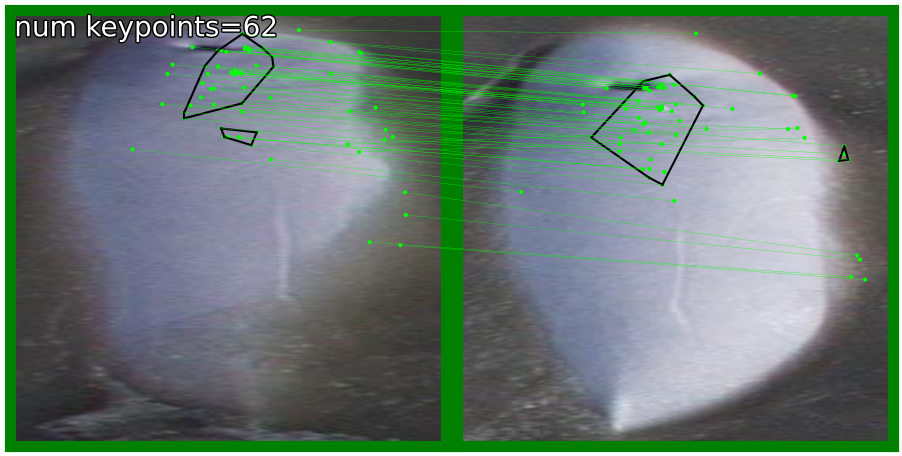

In [22]:
### Set up path to save images
saveroot = "/srv/transparency/wildbook_prototype/data/matches/figures/lightglue/"
os.makedirs(saveroot, exist_ok=True)

# Set up dataframe to store computed results
df = pd.DataFrame(columns=["query_idx", "match_idx", "score", "rank", "is_match", "query_kpts", "match_kpts", "query_hull", "match_hull"])

# Iterate through instance-match-indicator tuples
idx_to_match_idxs = {idx:{"topk_indices":topk_idx[idx].tolist(), "match_indicators":match_mat[idx].tolist()} for idx in range(len(images))}
for query_idx, vals in tqdm(idx_to_match_idxs.items()):
    # Extract query image
    image0 = images[query_idx]

    # Extract top-k indices of matches and whether they were true matches or not
    topk_indices = vals["topk_indices"]
    match_indicators = vals["match_indicators"]

    # Iterate through top-k matches
    rendered_images = []
    rendered_polygon_images = []
    for rank, (match_idx, is_match) in enumerate(zip(topk_indices, match_indicators)):
        # Extract match image
        image1 = images[match_idx]
        print(f"Query {query_idx} to Match {match_idx}")

        # Run LightGlue
        feats0, feats1, matches01 = _lightglue(image0, image1)

        # Visualize with lines and polygons
        savepath = Path(saveroot, f"lightglue_{query_idx}_{match_idx}.png")
        fig, axs, (m_kpts0, m_kpts1, hulls0, hulls1)  = _lightglue_vis(
            image0,
            image1,
            feats0,
            feats1,
            matches01,
            is_match=is_match,
            polygon_kwargs={"dbscan_kwargs":{"eps":0.4, "min_samples":3}},
            return_output=True
        )

        # Extract score of query-match pair
        score = distmat[query_idx, match_idx]

        # Store computed results
        data = {
            "query_idx":    query_idx,
            "match_idx":    match_idx,
            "score":        score,
            "rank":         rank,
            "is_match":     is_match,
            "query_kpts":   [m_kpts0],
            "match_kpts":   [m_kpts1],
            "query_hull":   [hulls0], 
            "match_hull":   [hulls1]
        }
        df = pd.concat((df, pd.DataFrame(data)), axis=1)
        
        # Save the rendered figure
        rendered_images.extend([fig2np(fig)])

    # Combine figures into one image and save
    plot_stacked_images(rendered_images)
    plt.savefig(Path(str(savepath).replace(savepath.name,""), f"lightglue_{query_idx}_all.png"))
    plt.close('all')
    break

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Get keypoints
f0, f1, m01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension

kpts0, kpts1, matches = f0["keypoints"].cpu(), f1["keypoints"].cpu(), m01["matches"].cpu()
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

# Normal scaling
X = StandardScaler().fit_transform(m_kpts0)

# Run DBSCAN
db = DBSCAN(eps=0.5, min_samples=3).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Extract core set
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Plot core vs non-core samples
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=5,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=3,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

### GradCam

In [ ]:
# INSERT GRADCAM INSTALLATION HERE #
#pip install ...

In [ ]:
# INSERT GRADCAM BOILERPLATE CODE HERE #
# imports

# helpers

# main functions
def _gradcam(*args):
    pass

def _vis_gradcam(*args):
    pass

In [ ]:
# BENCHMARK GRADCAM HERE #
#%timeit -n 100 _gradcam(random.choice(images), random.choice(images))

In [ ]:
# Iterate through instance-match pairs
idx_to_match_idxs = {idx:topk_idx[idx].tolist() for idx in range(len(images))}
for idx, match_idxs in tqdm(idx_to_match_idxs.items()):
    image0 = images[idx]
    for match in match_idxs:
        image1 = images[match]
        # INSERT GRADCAM VISUALIZATION CODE HERE #
        break
    break